In [40]:
import json
import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from transformers import AutoTokenizer, AutoModel

# load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter')
model = AutoModel.from_pretrained('allenai/specter')

In [9]:
f1 = open('Alzheimers.json')
f2 = open('Canc4er.json')

Alzheimers = json.load(f1)
Cancer = json.load(f2)

In [13]:
def embedding_(papers):
    # we can use a persistent dictionary (via shelve) so we can stop and restart if needed
    # alternatively, do the same but with embeddings starting as an empty dictionary
    embeddings = {}
    for pmid, paper in tqdm.tqdm(papers.items()):
        data = [paper["ArticleTitle"] + tokenizer.sep_token + paper["AbstractText"]]
        inputs = tokenizer(
            data, padding=True, truncation=True, return_tensors="pt", max_length=512
        )
        result = model(**inputs)
        # take the first token in the batch as the embedding
        embeddings[pmid] = result.last_hidden_state[:, 0, :].detach().numpy()[0]

    # turn our dictionary into a list
    embeddings = [embeddings[pmid] for pmid in papers.keys()]
    return embeddings

In [49]:
papers = Alzheimers.copy()
papers.update(Cancer)

In [51]:
embeddings = embedding_(papers)

100%|██████████| 2000/2000 [30:59<00:00,  1.08it/s]


In [52]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=3)
embeddings_pca_all = pd.DataFrame(
    pca.fit_transform(embeddings),
    columns=['PC0', 'PC1', 'PC2']
)
embeddings_pca_all["query"] = [paper["query"] for paper in papers.values()]

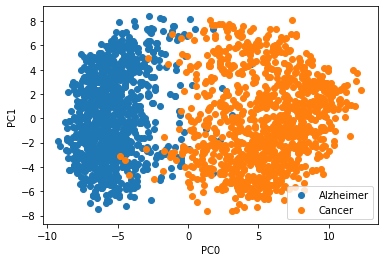

In [121]:
plt.scatter(embeddings_pca_all[embeddings_pca_all['query'] == 'Alzheimer']['PC0'], embeddings_pca_all[embeddings_pca_all['query'] == 'Alzheimer']['PC1'], label="Alzheimer")
plt.scatter(embeddings_pca_all[embeddings_pca_all['query'] == 'Cancer']['PC0'], embeddings_pca_all[embeddings_pca_all['query'] == 'Cancer']['PC1'], label="Cancer")
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.legend()
plt.savefig("README_img/EX2_3.png")
plt.show()

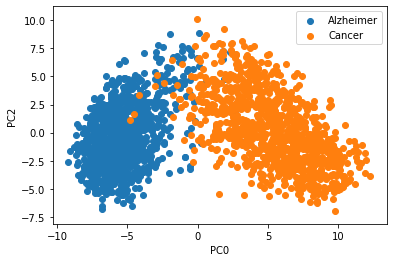

In [122]:
plt.scatter(embeddings_pca_all[embeddings_pca_all['query'] == 'Alzheimer']['PC0'], embeddings_pca_all[embeddings_pca_all['query'] == 'Alzheimer']['PC2'], label="Alzheimer")
plt.scatter(embeddings_pca_all[embeddings_pca_all['query'] == 'Cancer']['PC0'], embeddings_pca_all[embeddings_pca_all['query'] == 'Cancer']['PC2'], label="Cancer")
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.legend()
plt.savefig("README_img/EX2_4.png")
plt.show()

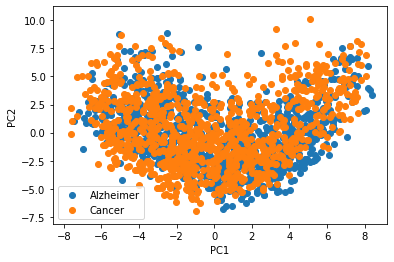

In [123]:
plt.scatter(embeddings_pca_all[embeddings_pca_all['query'] == 'Alzheimer']['PC1'], embeddings_pca_all[embeddings_pca_all['query'] == 'Alzheimer']['PC2'], label="Alzheimer")
plt.scatter(embeddings_pca_all[embeddings_pca_all['query'] == 'Cancer']['PC1'], embeddings_pca_all[embeddings_pca_all['query'] == 'Cancer']['PC2'], label="Cancer")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.savefig("README_img/EX2_5.png")
plt.show()

In [55]:
embeddings_pca_all

,PC0,PC1,PC2,query
0,-6.952025,2.151169,-4.292486,Alzheimer
1,-6.091127,-3.099970,0.176831,Alzheimer
2,-5.144713,-2.483867,0.643897,Alzheimer
3,-7.636140,-4.824004,2.221835,Alzheimer
4,-7.070122,-3.585453,-2.375718,Alzheimer
...,...,...,...,...
1995,4.881541,-2.351293,1.407387,Cancer
1996,1.630329,3.402599,6.384639,Cancer
1997,1.611991,-4.113490,2.973116,Cancer
1998,2.378570,-5.871854,3.056212,Cancer


# Using t-SNE to reduce dimension rather than PCA in EX2

In [115]:
import numpy as np
from sklearn.manifold import TSNE
# X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X = embeddings.copy()
X_embedded = TSNE(n_components=2, init='random', perplexity=50).fit_transform(X)
X_embedded

array([[ 27.199202 ,  29.84234  ],
       [-14.705733 ,  29.591877 ],
       [ -2.4990478,  22.61676  ],
       ...,
       [-27.807293 ,  21.404108 ],
       [ -1.7162204, -18.99909  ],
       [  1.3663787, -30.674278 ]], dtype=float32)

In [118]:
embeddings_tsne = pd.DataFrame(
    X_embedded,
    columns=['d1', 'd2']
)
embeddings_tsne["query"] = [paper["query"] for paper in papers.values()]
embeddings_tsne

,d1,d2,query
0,27.199202,29.842340,Alzheimer
1,-14.705733,29.591877,Alzheimer
2,-2.499048,22.616760,Alzheimer
3,-15.627184,16.742260,Alzheimer
4,-4.200918,37.387650,Alzheimer
...,...,...,...
1995,5.791800,-23.754789,Cancer
1996,35.513657,-9.130966,Cancer
1997,-27.807293,21.404108,Cancer
1998,-1.716220,-18.999090,Cancer


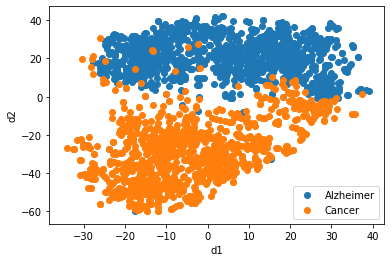

In [120]:
plt.scatter(X_embedded[:,0][:1000], X_embedded[:,1][:1000], label="Alzheimer")
plt.scatter(X_embedded[:,0][1000:], X_embedded[:,1][1000:], label="Cancer")
plt.xlabel("d1")
plt.ylabel("d2")
plt.legend()
plt.show()